# Transformer: Translation

На основе T5 (или любой другой) модели из библиотеки HuggingFace сделать переводчик

# LSTM

Спробуємо побудувати перекладач за допомогою Seq2Seq моделі на базі LSTM.
В якості прикладу коду будемо використовувати трохи модифікований приклад з документації Keras - https://keras.io/examples/nlp/lstm_seq2seq/

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

Спочатку спробуємо натренувати модель на кастомному датасеті з HuggingFace.
Використаємо цей датасет https://huggingface.co/datasets/PaulineSanchez/Translation_words_and_sentences_english_french/viewer/PaulineSanchez--Translation_words_and_sentences_english_french

In [3]:
dataset = load_dataset("PaulineSanchez/Translation_words_and_sentences_english_french", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/175466 [00:00<?, ? examples/s]

In [4]:
# Подивимось на речення з датасету
dataset[:5]

{'English words/sentences': ['Hi.', 'Run!', 'Run!', 'Who?', 'Wow!'],
 'French words/sentences': ['Salut!',
  'Cours\u202f!',
  'Courez\u202f!',
  'Qui ?',
  'Ça alors\u202f!']}

Можна побачити, що датасет містить якісь спецсимволи. Не будемо їх прибирати, щоб побачити чи вплине це на фінальну якість.

In [5]:
dataset["English words/sentences"][:5]

['Hi.', 'Run!', 'Run!', 'Who?', 'Wow!']

In [6]:
len(dataset)

175466

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
# Додамо для зручності функцію, яка буде відображати графічно результати тренування моделі
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [9]:
# Задамо деякі змінні
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000  # так як датасет у нас досить великий, для колабу введемо обмеження у 10к семплів

In [10]:
# Підготуємо датасет, створивши масиви з input текстами, target текстами, та масиви з символами
# У якості міток початку та кінця речення для таргету будемо використовувати спецсимволи табуляції та переносу строки
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

input_samples = dataset["English words/sentences"][:num_samples]
target_samples = dataset["French words/sentences"][:num_samples]

for idx, input_sample in enumerate(input_samples):
    target_text = "\t" + target_samples[idx] + "\n"

    input_texts.append(input_sample)
    target_texts.append(target_text)

    for char in input_sample:
        if char not in input_characters:
            input_characters.add(char)

    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)


input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 75
Number of unique output tokens: 94
Max sequence length for inputs: 40
Max sequence length for outputs: 59


In [11]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [12]:
# Для зручності створимо функцію, що буде робити векторизацію інпуту і таргетів
def vectorize(
    input_token_index,
    target_token_index,
    input_characters,
    target_characters,
    num_encoder_tokens,
    num_decoder_tokens,
    max_encoder_seq_length,
    max_decoder_seq_length,
):
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.0
        encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
        for t, char in enumerate(target_text):
            decoder_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0

    return encoder_input_data, decoder_input_data, decoder_target_data,

In [13]:
# Отримаємо векторизовані дані
encoder_input_data, decoder_input_data, decoder_target_data = vectorize(
    input_token_index,
    target_token_index,
    input_characters,
    target_characters,
    num_encoder_tokens,
    num_decoder_tokens,
    max_encoder_seq_length,
    max_decoder_seq_length,
)

In [14]:
# Також, для зручності створимо функцію, яка буде будувати модель
def build_model(num_encoder_tokens):
    encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    encoder_states = [state_h, state_c]

    decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

In [15]:
# Побудуємо модель
model = build_model(num_encoder_tokens)

In [16]:
# Зкомпілюємо модель та подивимось summart
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 75)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 94)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        339968      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

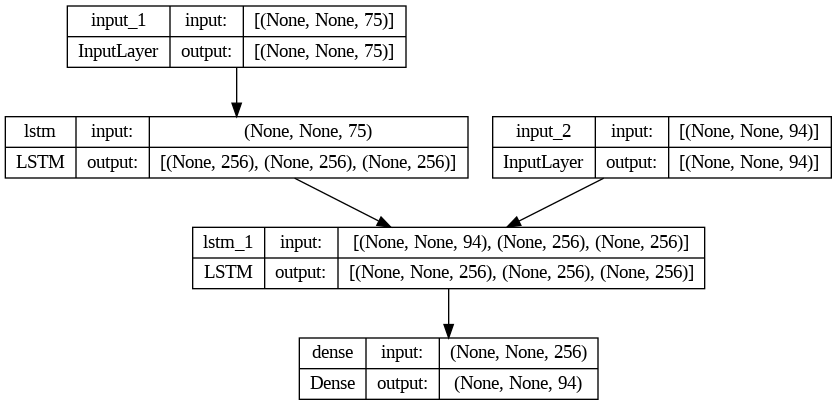

In [17]:
# Також можемо подивитись графічно на зв'язок слоїв у моделі
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
# Тренуємо модель
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 13s 22ms/step - loss: 1.2329 - accuracy: 0.7214 - val_loss: 1.1126 - val_accuracy: 0.6973
Epoch 2/100
125/125 [==============================] - 2s 14ms/step - loss: 0.9688 - accuracy: 0.7373 - val_loss: 1.0167 - val_accuracy: 0.7166
Epoch 3/100
125/125 [==============================] - 2s 15ms/step - loss: 0.8813 - accuracy: 0.7567 - val_loss: 0.9441 - val_accuracy: 0.7387
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.8045 - accuracy: 0.7771 - val_loss: 0.8483 - val_accuracy: 0.7577
Epoch 5/100
125/125 [==============================] - 2s 13ms/step - loss: 0.7217 - accuracy: 0.7934 - val_loss: 0.8026 - val_accuracy: 0.7686
Epoch 6/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6771 - accuracy: 0.8036 - val_loss: 0.7641 - val_accuracy: 0.7757
Epoch 7/100
125/125 [==============================] - 2s 13ms/step - loss: 0.6440 - accuracy: 0.8118 - val_loss: 0.7201 - val_accuracy

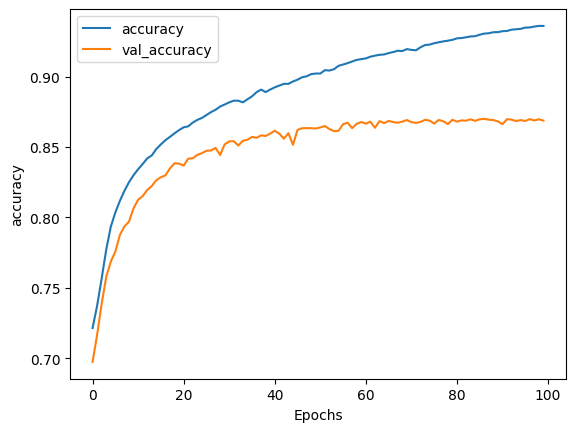

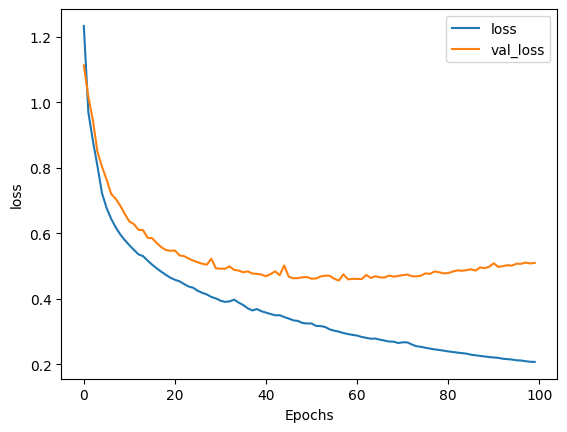

In [19]:
# Намалюємо графік зміни accuracy та loss моделі
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

По результатам моделі бачимо, що можливо є перенавчання на тренувальних даних. Але це може буду нормально, так як ми використали лише незначну частину тренувального датасету через обмеження колабу.

In [20]:
# Побудуємо функцію, що побудує з натренованої моделі окрему модель-енкодер та модель-декодер
def get_encoder_decoder_models(model):
    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_state_input_c = keras.Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
    return encoder_model, decoder_model

In [21]:
# Отримаємо енкодер та декодер
encoder_model, decoder_model = get_encoder_decoder_models(model)

In [22]:
# Побудуємо реверсивні індекси, щоб мати змогу перетворити послідовність у читабельне речення
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [23]:
# Створимо ще одну функцію, що буде відповідати за декодування послідовності
def decode_sequence(encoder_model, decoder_model, input_seq, reverse_input_char_index, reverse_target_char_index):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [24]:
import random

# Перекладемо 20 випадкових речень
for i in range(20):
    idx = random.randrange(0, len(encoder_input_data - 1))
    input_seq = encoder_input_data[idx : idx + 1]
    decoded_sentence = decode_sequence(encoder_model, decoder_model, input_seq, reverse_input_char_index, reverse_target_char_index)
    print("-")
    print("Input sentence:", input_texts[idx])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: We surrendered.
Decoded sentence: Nous sommes amissais.

-
Input sentence: Let's not go.
Decoded sentence: Restez alitée !

-
Input sentence: She is gentle.
Decoded sentence: Elle est actupate.

-
Input sentence: Tom is a pilot.
Decoded sentence: Tom est en train de plaiser.

-
Input sentence: Make it larger.
Decoded sentence: Personne n'est parti.

-
Input sentence: Tom's scared.
Decoded sentence: Tom est en train de plaiser.

-
Input sentence: I'm free now.
Decoded sentence: Je suis en train de parler.

-
Input sentence: She was naive.
Decoded sentence: Elle est actupate.

-
Input sentence: We want to go.
Decoded sentence: Nous sommes amissais.

-
Input sentence: You are drunk!
Decoded sentence: Vous êtes bizarres.

-
Input sentence: Who will win?
Decoded sentence: Qui est au lit ?

-
Input sentence: She grew roses.
Decoded sentence: Elle est actupate.

-
Input sentence: Hurry up, guys.
Decoded sentence: Prenez les miennes.

-
Input sentence: That's enough.
Decoded 

Можемо побачити, що перекладач працює, але не дуже гарно. Якість перекладу залишає бажати кращого. Це може бути спричинено якістю датасету. Давайте спробуємо натренувати таку ж саму модель на датасеті, що представлений у документації Keras.

In [25]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [26]:
# Робимо підготовку датасету. Цей датасет необхідно спочатку зчитати з файлу та також розбити на input/target та зробити відповідні списки символів
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open("fra.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [27]:
# Створимо індекси
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [28]:
# Отримаємо векторизовані дані
encoder_input_data, decoder_input_data, decoder_target_data = vectorize(
    input_token_index,
    target_token_index,
    input_characters,
    target_characters,
    num_encoder_tokens,
    num_decoder_tokens,
    max_encoder_seq_length,
    max_decoder_seq_length,
)

In [29]:
# Будуємо модель
model = build_model(num_encoder_tokens)

In [30]:
# Компілюємо модель, дивимось summary, та тренуємо
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 70)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 93)]   0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        334848      ['input_5[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

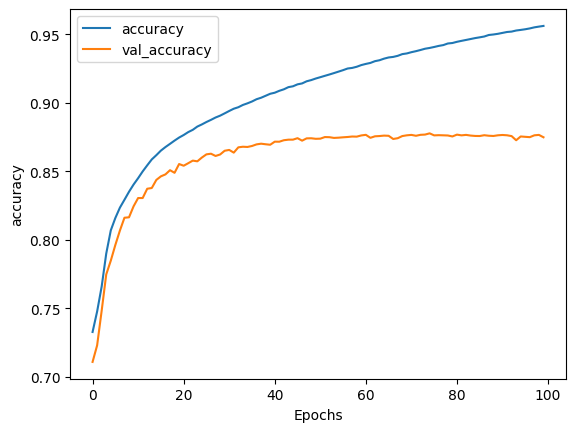

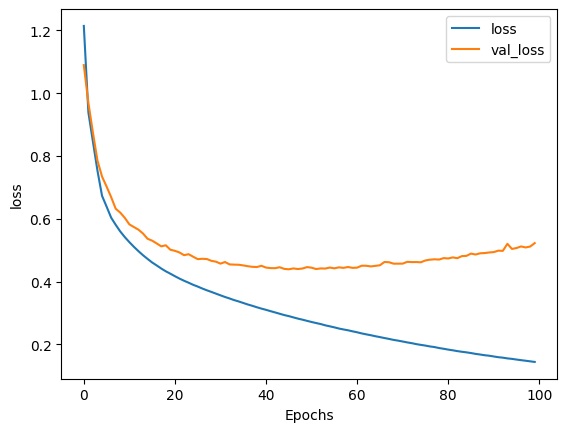

In [31]:
# Дивимось графіки історії тренування
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
# Отримаємо енкодер та декодер
encoder_model, decoder_model = get_encoder_decoder_models(model)

In [33]:
# Будуємо реверсивні індекси
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [35]:
# Подивимось на переклад 20-ти випадкових речень
for i in range(20):
    idx = random.randrange(0, len(encoder_input_data - 1))
    input_seq = encoder_input_data[idx : idx + 1]
    decoded_sentence = decode_sequence(encoder_model, decoder_model, input_seq, reverse_input_char_index, reverse_target_char_index)
    print("-")
    print("Input sentence:", input_texts[idx])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Who are you?
Decoded sentence: Qui est venu ?

-
Input sentence: Get down!
Decoded sentence: Décampe !

-
Input sentence: I never win.
Decoded sentence: Je n'en peuve pas.

-
Input sentence: It's funny.
Decoded sentence: C'est de la nourriture.

-
Input sentence: Be discreet.
Decoded sentence: Soyez sérieuse !

-
Input sentence: Remain seated.
Decoded sentence: Sers vons sortir.

-
Input sentence: Go home, Tom.
Decoded sentence: Va chez nous, maintenant !

-
Input sentence: That's lame.
Decoded sentence: C'est la mienne.

-
Input sentence: No way!
Decoded sentence: Mon œilu !

-
Input sentence: This is bad.
Decoded sentence: C'est de la nourriture.

-
Input sentence: Make me happy.
Decoded sentence: Attends à drève.

-
Input sentence: Be punctual.
Decoded sentence: Sois ponctuelle !

-
Input sentence: He spoke.
Decoded sentence: Il a précié lu pleur.

-
Input sentence: Take care!
Decoded sentence: Prends les miens.

-
Input sentence: I can't drive.
Decoded sentence: J

Цей переклад наче виглядає краще. Можно зробити висновок, що якість та чистота датасету впливає на якість перекладача. Тепер подивимось як з задачею перекладу впораються трансформери.

# HuggingFace

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

In [ ]:
# Спочатку спробуємо пайплайн з дефолтною T5 моделлю
en_ua_translator = pipeline("translation_en_to_de")
en_ua_translator("How are you?")

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[{'translation_text': 'Wie sind Sie?'}]

In [ ]:
# Тепер зробимо пайплайн з кастомною моделлю з HuggingFace
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
translator = pipeline("translation", model=model_checkpoint)
translator("Hi! My name is Alex. And what is your name? How old are you? What is your favorite music? Do you like hamsters? Everyone likes hamsters!")

[{'translation_text': 'Hola! Mi nombre es Alex. ¿Y cuál es tu nombre? ¿Cuántos años tienes? ¿Cuál es tu música favorita? ¿Te gustan los hámsters? ¡A todos les gustan los hámsters!'}]

Можем побачити, що трансформери з хабу HuggingFace дуже добре впоралися з великою кількістю тексту для перекладу.

# Висновок
В цій роботі був досліджений принцип побудови seq2seq моделі та реалізація перекладача на базі моделі з LSTM слоями. Також розглянули трансформери для цієї задачі.

Трансформери, як наступний шаг еволюції seq2seq моделей, мають значну перевагу у кількості слів у послідовності, з якою вони можуть працювати, та у якості вихідної послідовності.

Також побачили, що за допомогою хабу HuggingFace та їх бібліотеки `transformers` використання готових моделей та публічних датасетів відбувається через дуже зручний програмний API та потребує написання буквально декількох рядків коду.